<a href="https://colab.research.google.com/github/sonzwon/TIL_DL/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os

In [45]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


# voting ensemble

In [23]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
# hard voting
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [13]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [14]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [15]:
# soft voting
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

In [16]:
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [17]:
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# bagging

- 단일 결정트리 vs 배깅

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [37]:
# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

# Bagging
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                            random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

print('Decision Tree accuracy : ', accuracy_score(y_test, y_pred_tree))
print('Bagging accuracy : ', accuracy_score(y_test, y_pred_bag))

Decision Tree accuracy :  0.856
Bagging accuracy :  0.904


그림 저장: decision_tree_without_and_with_bagging_plot


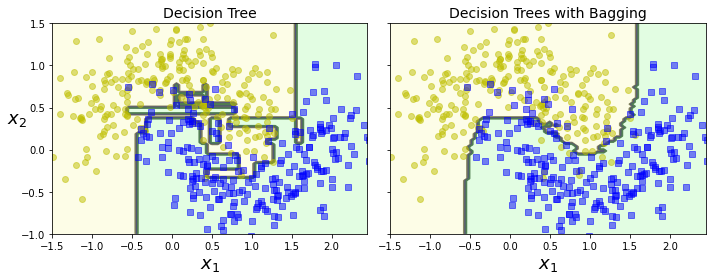

In [47]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- oob 평가

In [23]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            oob_score=True,
                            bootstrap=True,
                            random_state=40)
bag_clf.fit(X_train, y_train)
print('oob_score : ',bag_clf.oob_score_)
print('oob_decision_function : ', bag_clf.oob_decision_function_)

oob_score :  0.8986666666666666
oob_decision_function :  [[0.32275132 0.67724868]
 [0.34117647 0.65882353]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.09497207 0.90502793]
 [0.31147541 0.68852459]
 [0.01754386 0.98245614]
 [0.97109827 0.02890173]
 [0.97765363 0.02234637]
 [0.74404762 0.25595238]
 [0.         1.        ]
 [0.7173913  0.2826087 ]
 [0.85026738 0.14973262]
 [0.97222222 0.02777778]
 [0.0625     0.9375    ]
 [0.         1.        ]
 [0.97837838 0.02162162]
 [0.94642857 0.05357143]
 [1.         0.        ]
 [0.01704545 0.98295455]
 [0.39473684 0.60526316]
 [0.88700565 0.11299435]
 [1.         0.        ]
 [0.97790055 0.02209945]
 [0.         1.        ]
 [0.99428571 0.00571429]
 [1.         0.        ]
 [0.         1.        ]
 [0.62569832 0.37430168]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.13402062 0.86597938]
 [1.         0.        ]
 [0.         1.        ]
 [0.38251366 0.617

- Bagging 1) RandomForest

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(y_pred_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


In [26]:
bag_rf_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
                               n_estimators=500,
                               random_state=42)
bag_rf_clf.fit(X_train, y_train)
y_pred_bag_rf = bag_rf_clf.predict(X_test)
print(y_pred_bag_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


In [30]:
np.sum(y_pred_bag_rf == y_pred_rf)/len(y_pred_bag_rf)  # 예측 결과가 동일함

1.0

- 변수 중요도 계산

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


- 변수 중요도 시각화

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [5]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(n_estimators=500, random_state=42)

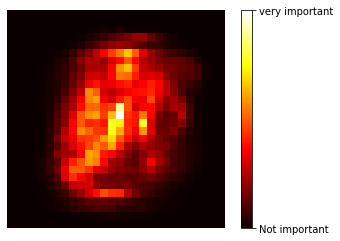

In [39]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'very important'])
plt.savefig('mnist_feature_importance_plot')
plt.show()

# Boosting

- Adaboost

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

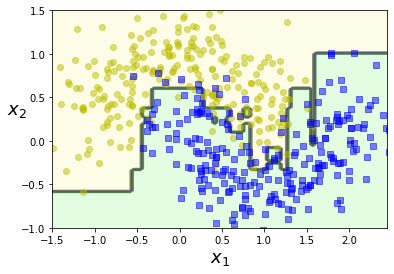

In [35]:
plot_decision_boundary(ada_clf, X, y)

그림 저장: boosting_plot


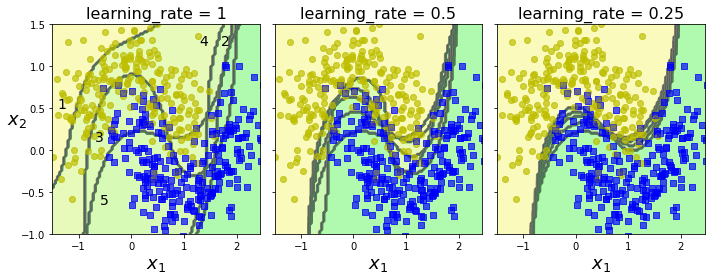

In [49]:
m = len(X_train)

fix, axes = plt.subplots(ncols=3, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5), (2, 0.25)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-1.4,  0.50, "1", fontsize=14)
        plt.text( 1.7,  1.25, "2", fontsize=14)
        plt.text(-0.7,  0.10, "3", fontsize=14)
        plt.text( 1.3,  1.25, "4", fontsize=14)
        plt.text(-0.6, -0.65, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

- Gradient Boosting

In [55]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [57]:
# y2 첫번쨰 결정트리에서의 오차
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [58]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [60]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

그림 저장: gradient_boosting_plot


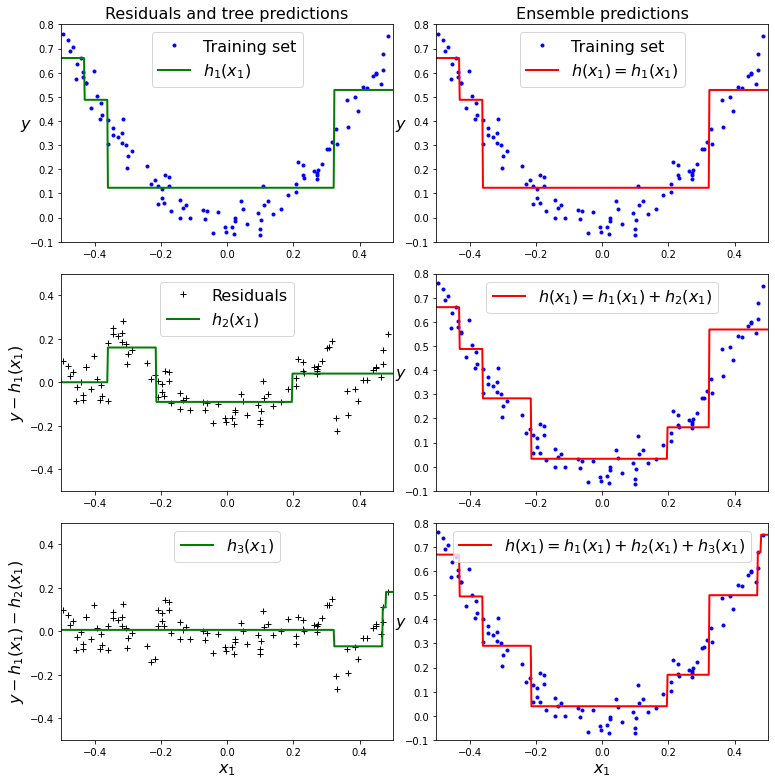

In [61]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [63]:
# estimators 3 vs 200
from sklearn.ensemble import GradientBoostingRegressor
gbrt3 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt3.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [64]:
gbrt200 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=1.0, random_state=42)
gbrt200.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=200,
                          random_state=42)

그림 저장: gbrt_learning_rate_plot


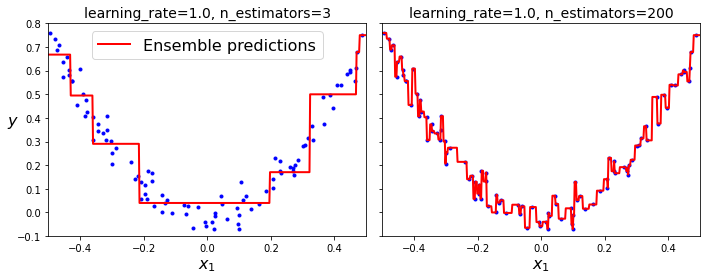

In [66]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt3.learning_rate, gbrt3.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt200], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt200.learning_rate, gbrt200.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()